# Beetles: choice of link function

*Pourouchottamin Kalyan* \
*Caillat Maéva* \
*Vlieghe Manon*

#Jeu de données et contexte

http://www.openbugs.net/Examples/Beetles.html


Dobson (1983) analyse les données dose-réponse binaires publiées par Bliss (1935), dans lesquelles est enregistré le nombre de coléoptères tués après avoir subi une exposition de 5 heures au sulfure de carbone, pour N = 8 concentrations différentes.

Nous supposons que le nombre de décès observés $r_i$ à chaque concentration $x_i$ suit une loi binomiale, avec $n_i$ la taille de l'échantillon et $p_i$ la probabilité de décès. Les modèles plausibles pour $p_i$ incluent les modèles logistique, probit et valeur extrême (log-log complémentaire), que nous développerons plus bas.

Ainsi, on a : $$r_i | x_i \stackrel{ind}{\sim} Binomial(n_i, p_i)$$
et 3 modèles pour $p_i$.



In [0]:
#Import des bibiothèques

%matplotlib inline
from math import *
import numpy as  np
from pylab import *
from numpy import random as rd
from matplotlib import pyplot as plt
from scipy.stats import norm, binom, lognorm, uniform
import pandas as pd
from statistics import median

In [2]:
#Jeu de données

data = np.array([[1.6907, 59, 6],
                 [1.7242, 60, 13],
                 [1.7552, 62, 18],
                 [1.7842, 56, 28],
                 [1.8113, 63, 52],
                 [1.8369, 59, 53],
                 [1.8610, 62, 61],
                 [1.8839, 60, 60]])

print(data)

[[ 1.6907 59.      6.    ]
 [ 1.7242 60.     13.    ]
 [ 1.7552 62.     18.    ]
 [ 1.7842 56.     28.    ]
 [ 1.8113 63.     52.    ]
 [ 1.8369 59.     53.    ]
 [ 1.861  62.     61.    ]
 [ 1.8839 60.     60.    ]]


# I- Première modélisation de $p_i$ : modèle logistique

$$p_i = \frac{\exp(\alpha + \beta x_i )} {1 + exp( \alpha + \beta x_i )}$$
Pour les paramètres $\alpha$ et $\beta$, on considère deux marches aléatoires symétriques normales :
$$\alpha_* = \alpha_t + \epsilon_t$$ 
$$\beta_* = \beta_t + \epsilon_t $$
$$\epsilon_t \stackrel{ind}{\sim} \mathcal{N}(0,1)$$
Et la probabilité d'acceptation s'écrit alors :
$$\alpha(X_t, X_*) =  min(1, \frac{g(X_*)}{g(X_t)}) = min(1, \frac{\pi(\alpha_*, \beta_* | x_i, r_i)}{\pi(\alpha_t, \beta_t | x_i, r_i)})$$
Or :
$$\pi(\alpha, \beta | x_i, r_i) \propto {\prod \limits_{i=1}^n f(r_i | x_i)} {\pi(\alpha, \beta)} $$

## 1-Metropolis-Hasting

In [0]:
def MH_logit(sigma, N, X0, data):
    #sigma: écart-type du noyau de proposition (ici: marche aléatoire symétrique normale)
    #N: longueur de la chaîne de Markov
    #X0: état initial de la chaîne de Markov
    #data: jeu de données, i.e. matrice 8x3 (xi,ni,ri)

    #xi: concentration
    x = data[:,0]
    m = np.mean(x)
    #on centre les données pour rendre les paramètres un peu plus orthogonaux
    #cela facilite l'acceptation des données
    x = x - m
    #nombre de scarabées
    n = data[:,1]
    #nombre de scarabées tués
    r = data[:,2]
    
    chaine = np.zeros((N,2))
    chaine[0,:] = X0
    acc_rate = 0
    
    for t in range(1,N):
        current = chaine[t-1,:]
        prop_alpha = norm.rvs(loc = current[0], scale = sigma[0])
        prop_beta = norm.rvs(loc = current[1], scale = sigma[1])
        prop_p = np.exp(prop_alpha + prop_beta*x)/(1 + np.exp(prop_alpha + prop_beta*x))      
        prop = np.array([prop_alpha, prop_beta])
        
        current_p = np.exp(current[0] + current[1]*x)/(1 + np.exp(current[0] + current[1]*x))
        
        top = sum([binom.logpmf(r[i], n[i], prop_p[i]) for i in range(len(r))]) 
        bottom = sum([binom.logpmf(r[i], n[i], current_p[i]) for i in range(len(r))])
            
        acc_proba = min(1, np.exp(top-bottom))
        u = rd.uniform(0,1)
        if (u<acc_proba):
            chaine[t,:] = prop
            acc_rate += 1
        else:
            chaine[t,:] = current
    #Comme on avait centré initialement
    chaine[:,0] = chaine[:,0]  - m*chaine[:,1]
    print("Acceptance rate: ", acc_rate/N)    
    return(chaine)

In [4]:
sigma = np.array([0.3,5])
#1000 itérations pour la burning period, suivies de 10 000 itérations
N = 1000 + 10**4
X0 = np.array([0, 0])

chaine1MH = MH_logit(sigma, N, X0, data)

Acceptance rate:  0.2863636363636364


Le taux d'acceptation vaut environ 30%, ce qui semble peu pour un problème en petite dimension (ici 2) où le taux d'acceptation doit être proche de 50%.

In [5]:
alpha1MH = chaine1MH[1001:,0]
beta1MH = chaine1MH[1001:,1]
d = {'Name':pd.Series(['alpha','beta']),
   'Alpha':pd.Series(alpha1MH),
   'Beta':pd.Series(beta1MH)
}
df = pd.DataFrame(d)
print(df.describe())

             Alpha         Beta
count  9999.000000  9999.000000
mean    -61.650623    34.795533
std       5.142881     2.891918
min     -82.986676    26.501996
25%     -65.080699    32.766275
50%     -61.498737    34.724509
75%     -58.095871    36.729351
max     -46.838152    46.691722


On retrouve donc les mêmes valeurs qu'OpenBUGS.

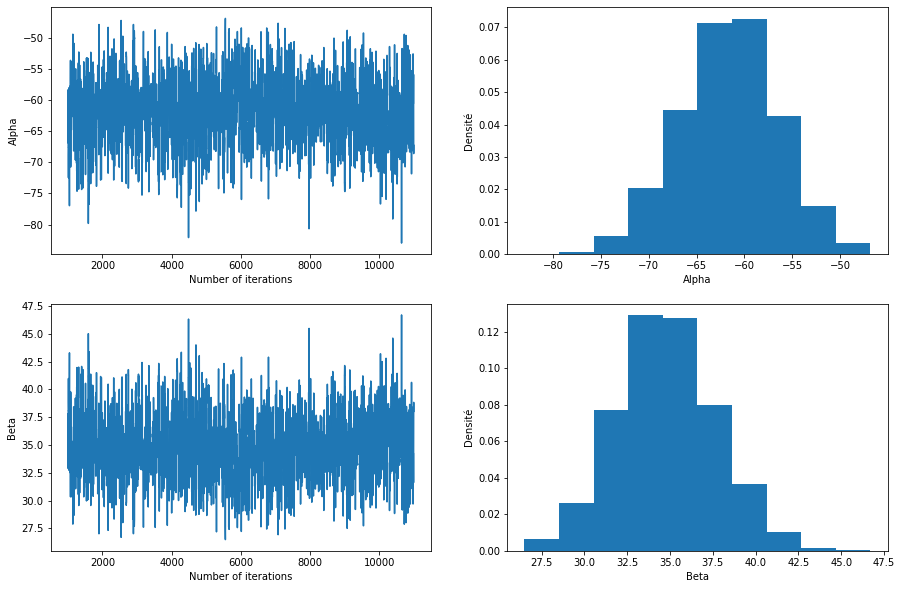

In [6]:
x = np.arange(1001, 1001+len(alpha1MH))
figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(x, alpha1MH)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha")

plt.subplot(2,2,2)
plt.hist(alpha1MH, density=True)
plt.xlabel("Alpha")
plt.ylabel("Densité")

plt.subplot(2,2,3)
plt.plot(x, beta1MH)
plt.xlabel("Number of iterations")
plt.ylabel("Beta")

plt.subplot(2,2,4)
plt.hist(beta1MH, density=True)
plt.xlabel("Beta")
plt.ylabel("Densité")

plt.show()

La chaîne a des bonnes propriétés de mélange.

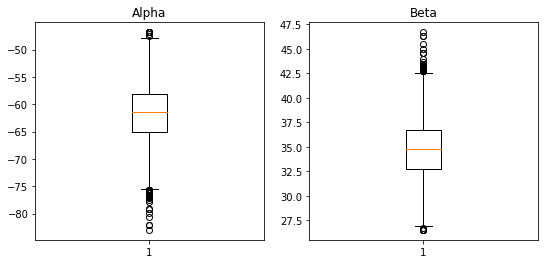

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title('Alpha')
ax[0].boxplot(alpha1MH)
ax[1].set_title('Beta')
ax[1].boxplot(beta1MH)
plt.show()

D'après ces graphes, tout semble bon donc nous pouvons continuer notre analyse et essayer d'interpréter nos résultats.
Tout d'abord, $\beta > 0$, donc augmenter la concentration de carbone disulphide faire accroître la probabilité que le scarabée meurt, ce qui est logique.
On cherche maintenant comment l'augmentation d'une unité augmente la dose :
\begin{equation*}
 \text{odds ratio} \stackrel{\text{def}}{=} \frac{p(x_i + 1) / (1 - p(x_i+1))}{p(x_i) / (1 - p(x_i))} =  \frac{\exp(\alpha + \beta (x_i + 1))}{exp(\alpha + \beta x_i)} = \exp(\beta).
\end{equation*}
On obtient la médiane a posteriori pour cet odds ratio, ainsi qu'un intervalle de confiance à 95%, grâce à notre chaîne de Markov :


In [8]:
odds_ratio = np.exp(beta1MH)
post_mean = median(odds_ratio)
q1 = np.quantile(odds_ratio, 0.025)
q2 = np.quantile(odds_ratio, 0.975)
print("Médiane a posteriori", post_mean)
print("Quantile 2.5% a posteriori", q1)
print("Quantile 97.5% a posteriori", q2)

Médiane a posteriori 1204100385108987.2
Quantile 2.5% a posteriori 5566105388928.295
Quantile 97.5% a posteriori 4.346917266978353e+17


Ainsi, on peut dire qu'une augmentation de 1 unité dans la dose, augmente la probabilité de mort d'environ $10^{15}$, et l'incertitude est très grande, sûrement à cause du nombre limité de données.
<br>
A présent, cherchons la loi a posteriori de $LD_{50}$, i.e. la dose pour laquelle la probabilité de mort est de 50%. Conditionnellement à $(\alpha, \beta)^T$, on a :
$$p_i = 0.5 \iff \alpha + \beta x_i = 0 \iff x_i = -\frac{\alpha}{\beta} $$
Ainsi :
$$LD_{50} = -\frac{\alpha}{\beta} $$
Et voici sa loi a posteriori obtenue à partir de la chaîne de Markov :

Text(0, 0.5, 'Densité')

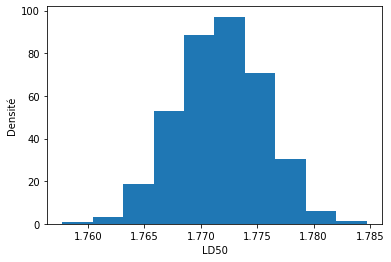

In [9]:
LD50 = -alpha1MH / beta1MH
plt.hist(LD50, density=True)
plt.xlabel("LD50")
plt.ylabel("Densité")

## 2-Gibbs avec MH

In [0]:
def Gibbs_mort1(sigma, N, X0, data):
    Y = data[:,2]
    x = data[:,0]
    m = np.mean(x)
    x = x - m
    n = data[:,1]
    
    chaine = np.zeros((N+1,2))
    chaine[0,:] = X0
    acc_rate_a, acc_rate_b = 0,0
    
    for t in range(N):
        current = chaine[t,:]
        
        #alpha
        prop_alpha = norm.rvs(loc = current[0], scale = sigma[0])
        
        prop_p_a = np.exp(prop_alpha + current[1]*x)/(1 + np.exp(prop_alpha + current[1]*x))
        current_p_a = np.exp(current[0] + current[1]*x)/(1 + np.exp(current[0] + current[1]*x))
        
        topa = sum([binom.logpmf(Y[i], n[i], prop_p_a[i]) for i in range(len(Y))]) 
        bottoma = sum([binom.logpmf(Y[i], n[i], current_p_a[i]) for i in range(len(Y))])
        acc_proba_a = min(1, np.exp(topa-bottoma))
        u = rd.uniform(0,1)
        if (u<acc_proba_a):
            chaine[t+1,0] = prop_alpha
            acc_rate_a += 1
        else:
            chaine[t+1,0] = current[0]
        
        #beta
        current[0] = chaine[t+1,0]
        prop_beta = norm.rvs(loc = current[1], scale = sigma[1])
        
        prop_p_b = np.exp(current[0] + prop_beta*x)/(1 + np.exp(current[0] + prop_beta*x))
        current_p_b = np.exp(current[0] + current[1]*x)/(1 + np.exp(current[0] + current[1]*x))
        
        topb = sum([binom.logpmf(Y[i], n[i], prop_p_b[i]) for i in range(len(Y))]) 
        bottomb = sum([binom.logpmf(Y[i], n[i], current_p_b[i]) for i in range(len(Y))])
        acc_proba_b = min(1, np.exp(topb-bottomb))
        u = rd.uniform(0,1)
        if (u<acc_proba_b):
            chaine[t+1,1] = prop_beta
            acc_rate_b += 1
        else:
            chaine[t+1,1] = current[1]
    
    chaine[:,0] = chaine[:,0]  - m*chaine[:,1]
    
    print("acceptation alpha : ", acc_rate_a/N)
    print("acceptation beta : ", acc_rate_b/N) 
    return(chaine)

In [11]:
sigma = np.array([0.3,5])
N = 1000 + 10**4

X0 = np.array([0, 0])

chaine1G = Gibbs_mort1(sigma, N, X0, data)

acceptation alpha :  0.4598181818181818
acceptation beta :  0.5289090909090909


Le taux d'acceptation vaut environ 50% pour les deux paramètres, ce qui est en accord avec la règle des les échantillonneurs MCMC en petite dimension (2).

In [12]:
alpha1G = chaine1G[1001:,0]
beta1G = chaine1G[1001:,1]
d = {'Name':pd.Series(['alpha','beta']),
   'Alpha':pd.Series(alpha1G),
   'Beta':pd.Series(beta1G)
}
df = pd.DataFrame(d)
print(df.describe())

              Alpha          Beta
count  10000.000000  10000.000000
mean     -61.281672     34.586972
std        5.256369      2.956581
min      -80.247876     25.570166
25%      -64.676883     32.597017
50%      -61.109234     34.481873
75%      -57.738103     36.494516
max      -45.093846     45.248893


On retrouve donc les mêmes valeurs qu'OpenBUGS.

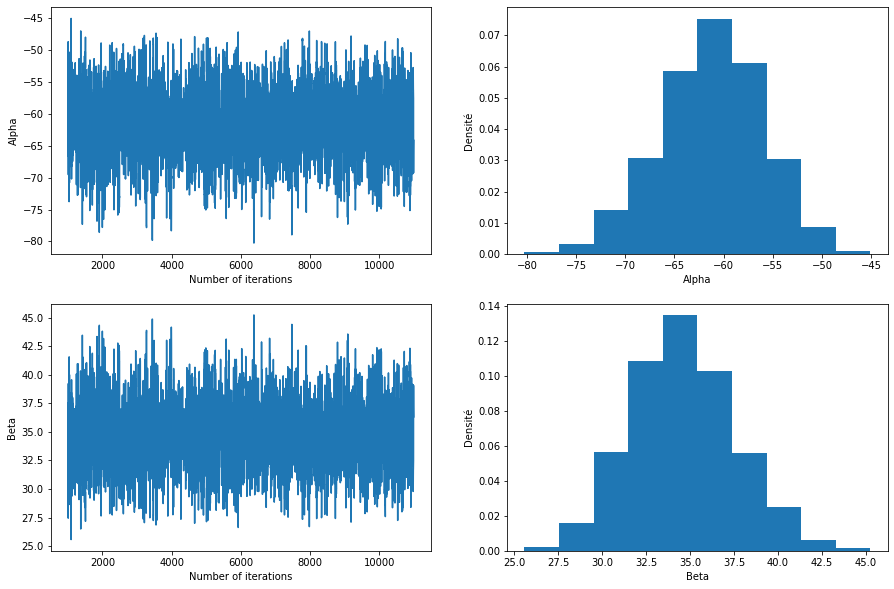

In [13]:
x = np.arange(1001, 1001+len(alpha1G))
figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(x, alpha1G)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha")

plt.subplot(2,2,2)
plt.hist(alpha1G, density=True)
plt.xlabel("Alpha")
plt.ylabel("Densité")

plt.subplot(2,2,3)
plt.plot(x, beta1G)
plt.xlabel("Number of iterations")
plt.ylabel("Beta")

plt.subplot(2,2,4)
plt.hist(beta1G, density=True)
plt.xlabel("Beta")
plt.ylabel("Densité")

plt.show()

La chaîne a des bonnes propriétés de mélange.

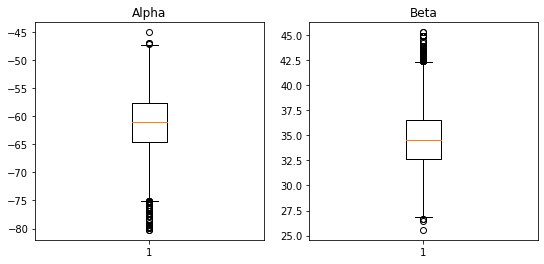

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title('Alpha')
ax[0].boxplot(alpha1G)
ax[1].set_title('Beta')
ax[1].boxplot(beta1G)
plt.show()

D'après ces graphes, tout semble bon. L'analyse et l'interprétation des résultats sont les mêmes que pour le Métropolis-Hasting ci-dessus.

# II- Deuxième modélisation de $p_i$ : modèle probit

$$p_i = \phi( \alpha + \beta x_i )$$
avec $\phi$ la fonction de répartition d'une loi normale centrée réduite.
<br>Pour les paramètres $\alpha$ et $\beta$, on considère deux marches aléatoires symétriques normales :
$$\alpha_* = \alpha_t + \epsilon_t$$ 
$$\beta_* = \beta_t + \epsilon_t $$
$$\epsilon_t \stackrel{ind}{\sim} \mathcal{N}(0,1)$$
Et la probabilité d'acceptation s'écrit alors :
$$\alpha(X_t, X_*) =  min(1, \frac{g(X_*)}{g(X_t)}) = min(1, \frac{\pi(\alpha_*, \beta_* | x_i, r_i)}{\pi(\alpha_t, \beta_t | x_i, r_i)})$$
Or :
$$\pi(\alpha, \beta | x_i, r_i) \propto {\prod \limits_{i=1}^n f(r_i | x_i)} {\pi(\alpha, \beta)} $$

## 1-Metropolis-Hasting

In [0]:
def MH_probit(sigma, N, X0, data):
    #sigma: écart-type du noyau de proposition (ici: marche aléatoire symétrique normale)
    #N: longueur de la chaîne de Markov
    #X0: état initial de la chaîne de Markov
    #data: jeu de données, i.e. matrice 8x3 (xi,ni,ri)

    #xi: concentration
    x = data[:,0]
    m = np.mean(x)
    #on centre les données pour rendre les paramètres un peu plus orthogonaux
    #cela facilite l'acceptation des données
    x = x - m
    #nombre de scarabées
    n = data[:,1]
    #nombre de scarabées tués
    r = data[:,2]
    
    chaine = np.zeros((N,2))
    chaine[0,:] = X0
    acc_rate = 0
    
    for t in range(1,N):
        current = chaine[t-1,:]
        prop_alpha = norm.rvs(loc = current[0], scale = sigma[0])
        prop_beta = norm.rvs(loc = current[1], scale = sigma[1])
        prop_p = norm.cdf(prop_alpha + prop_beta*x)    
        prop = np.array([prop_alpha, prop_beta])
        
        current_p = norm.cdf(current[0] + current[1]*x)
        
        top = sum([binom.logpmf(r[i], n[i], prop_p[i]) for i in range(len(r))]) 
        bottom = sum([binom.logpmf(r[i], n[i], current_p[i]) for i in range(len(r))])
            
        acc_proba = min(1, np.exp(top-bottom))
        u = rd.uniform(0,1)
        if (u<acc_proba):
            chaine[t,:] = prop
            acc_rate += 1
        else:
            chaine[t,:] = current
    #Comme on avait centré initialement
    chaine[:,0] = chaine[:,0]  - m*chaine[:,1]
    print("Acceptance rate: ", acc_rate/N)    
    return(chaine)

In [16]:
sigma = np.array([0.15,2.5])
#1000 itérations pour la burning period, suivies de 10 000 itérations
N = 1000 + 10**4
X0 = np.array([0, 0])

chaine2MH = MH_probit(sigma, N, X0, data)

Acceptance rate:  0.3058181818181818


Le taux d'acceptation vaut environ 30%, ce qui n'est pas en accord avec la règle des les échantillonneurs MCMC en petite dimension (50%).

In [17]:
alpha2MH = chaine2MH[1001:,0]
beta2MH = chaine2MH[1001:,1]
d = {'Name':pd.Series(['alpha','beta']),
   'Alpha':pd.Series(alpha2MH),
   'Beta':pd.Series(beta2MH)
}
df = pd.DataFrame(d)
print(df.describe())

             Alpha         Beta
count  9999.000000  9999.000000
mean    -35.154938    19.851651
std       2.588829     1.457437
min     -44.709853    15.048355
25%     -36.848291    18.847102
50%     -35.121132    19.822265
75%     -33.386272    20.812997
max     -26.493101    25.218766


On retrouve donc les mêmes valeurs qu'OpenBUGS.

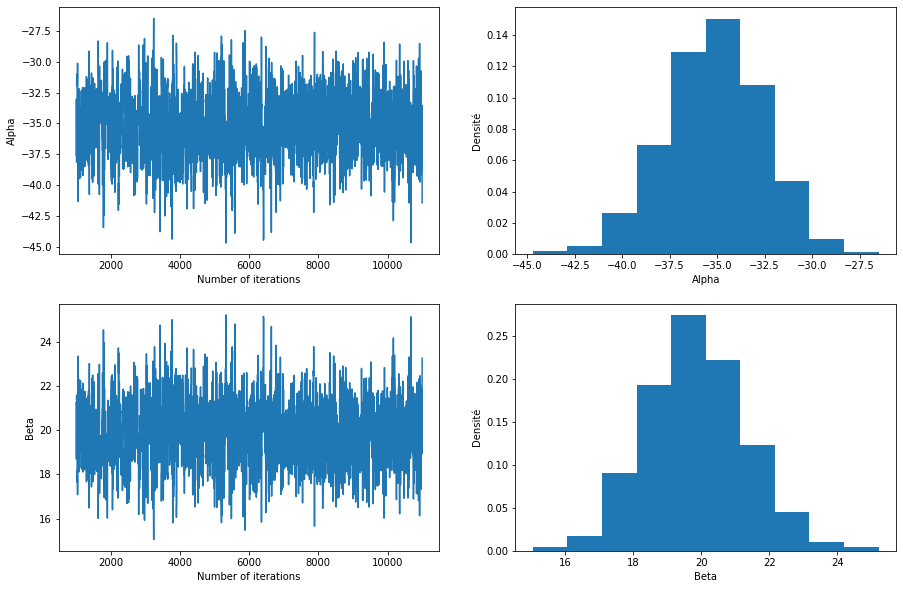

In [18]:
x = np.arange(1001, 1001+len(alpha2MH))
figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(x, alpha2MH)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha")

plt.subplot(2,2,2)
plt.hist(alpha2MH, density=True)
plt.xlabel("Alpha")
plt.ylabel("Densité")

plt.subplot(2,2,3)
plt.plot(x, beta2MH)
plt.xlabel("Number of iterations")
plt.ylabel("Beta")

plt.subplot(2,2,4)
plt.hist(beta2MH, density=True)
plt.xlabel("Beta")
plt.ylabel("Densité")

plt.show()

La chaîne a des bonnes propriétés de mélange.

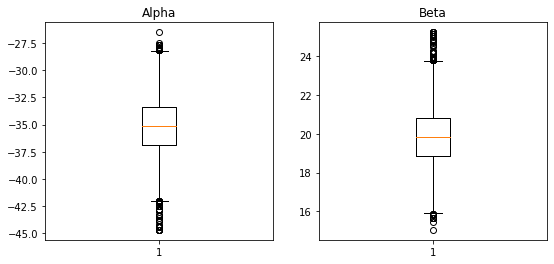

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title('Alpha')
ax[0].boxplot(alpha2MH)
ax[1].set_title('Beta')
ax[1].boxplot(beta2MH)
plt.show()

D'après ces graphes, tout semble bon donc nous pouvons continuer notre analyse et essayer d'interpréter nos résultats.
Tout d'abord, $\beta > 0$, donc augmenter la concentration de carbone disulphide faire accroître la probabilité que le scarabée meurt, ce qui est logique.
On ne cherche pas l'odds ratio cette fois, car c'est beaucoup moins parlant pour un modèle probit que pour un modèle logit.


A présent, cherchons la loi a posteriori de $LD_{50}$, i.e. la dose pour laquelle la probabilité de mort est de 50%. Conditionnellement à $(\alpha, \beta)^T$, on a :
$$p_i = 0.5 \iff P(X \leq \alpha + \beta x_i) = 0.5 $$ 
$$\iff \alpha + \beta x_i = med(N(0,1)) = 0 \iff x_i = -\frac{\alpha}{\beta} $$
Ainsi :
$$LD_{50} = -\frac{\alpha}{\beta} $$
Et voici sa loi a posteriori obtenue à partir de la chaîne de Markov :

Text(0, 0.5, 'Densité')

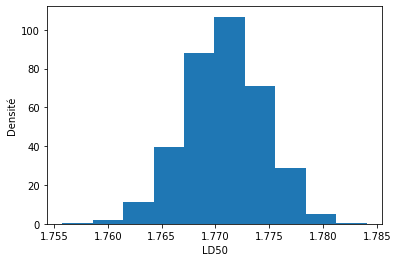

In [20]:
LD50 = -alpha2MH / beta2MH
plt.hist(LD50, density=True)
plt.xlabel("LD50")
plt.ylabel("Densité")

## 2-Gibbs avec MH

In [0]:
def Gibbs_mort2(sigma, N, X0, data):
    Y = data[:,2]
    x = data[:,0]
    m = np.mean(x)
    x = x - m
    n = data[:,1]
    
    chaine = np.zeros((N+1,2))
    chaine[0,:] = X0
    acc_rate_a, acc_rate_b = 0,0
    
    for t in range(N):
        current = chaine[t,:]
        
        #alpha
        prop_alpha = norm.rvs(loc = current[0], scale = sigma[0])

        prop_p_a = norm.cdf(prop_alpha + current[1]*x) 
        current_p_a = norm.cdf(current[0] + current[1]*x)
        
        #passer au log car valeurs trop grandes
        topa = sum([binom.logpmf(Y[i], n[i], prop_p_a[i]) for i in range(len(Y))]) 
        bottoma = sum([binom.logpmf(Y[i], n[i], current_p_a[i]) for i in range(len(Y))])
        acc_proba_a = min(1, np.exp(topa-bottoma))
        u = rd.uniform(0,1)
        if (u<acc_proba_a):
            chaine[t+1,0] = prop_alpha
            acc_rate_a += 1
        else:
            chaine[t+1,0] = current[0]
        
        #beta
        current[0] = chaine[t+1,0]
        prop_beta = norm.rvs(loc = current[1], scale = sigma[1])

        prop_p_b = norm.cdf(current[0] + prop_beta*x) 
        current_p_b = norm.cdf(current[0] + current[1]*x)

        #passer au log car valeurs trop grandes
        topb = sum([binom.logpmf(Y[i], n[i], prop_p_b[i]) for i in range(len(Y))]) 
        bottomb = sum([binom.logpmf(Y[i], n[i], current_p_b[i]) for i in range(len(Y))])
        acc_proba_b = min(1, np.exp(topb-bottomb))
        u = rd.uniform(0,1)
        if (u<acc_proba_b):
            chaine[t+1,1] = prop_beta
            acc_rate_b += 1
        else:
            chaine[t+1,1] = current[1]
    
    chaine[:,0] = chaine[:,0]  - m*chaine[:,1]
      
    print("acceptation alpha : ", acc_rate_a/N)
    print("acceptation beta : ", acc_rate_b/N) 
    return(chaine)

In [22]:
sigma = np.array([0.15,2.5])
N = 1000 + 10**4

X0 = np.array([0, 0])

chaine2G = Gibbs_mort2(sigma, N, X0, data)

acceptation alpha :  0.4970909090909091
acceptation beta :  0.5469090909090909


Le taux d'acceptation vaut environ 50% pour les deux paramètres, ce qui est en accord avec la règle des les échantillonneurs MCMC en petite dimension (2).

In [23]:
alpha2G = chaine2G[1001:,0]
beta2G = chaine2G[1001:,1]
d = {'Name':pd.Series(['alpha','beta']),
   'Alpha':pd.Series(alpha2G),
   'Beta':pd.Series(beta2G)
}
df = pd.DataFrame(d)
print(df.describe())

              Alpha          Beta
count  10000.000000  10000.000000
mean     -35.040092     19.787619
std        2.612573      1.470299
min      -45.244541     13.561896
25%      -36.836936     18.762964
50%      -35.031941     19.792527
75%      -33.223029     20.790510
max      -23.930197     25.545784


On retrouve donc les mêmes valeurs qu'OpenBUGS.

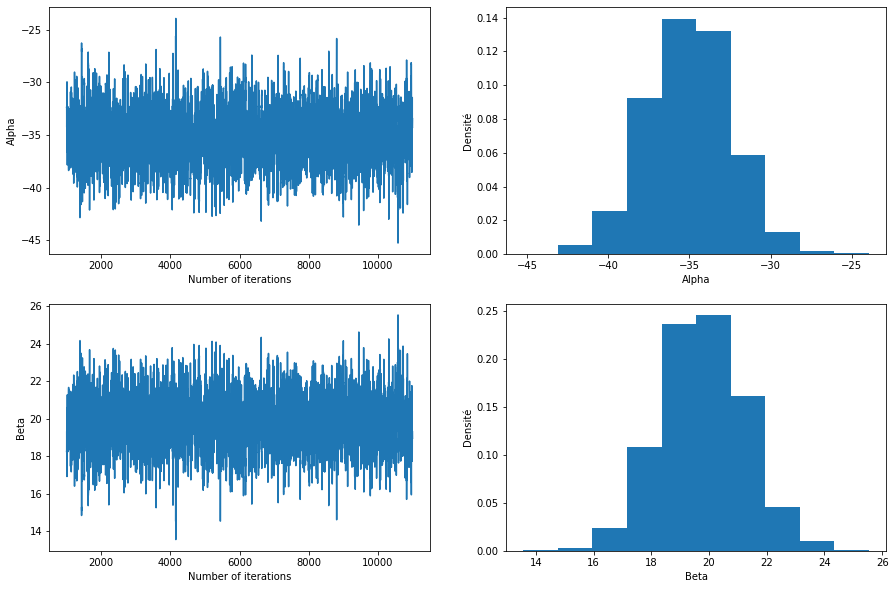

In [24]:
x = np.arange(1001, 1001+len(alpha2G))
figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(x, alpha2G)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha")

plt.subplot(2,2,2)
plt.hist(alpha2G, density=True)
plt.xlabel("Alpha")
plt.ylabel("Densité")

plt.subplot(2,2,3)
plt.plot(x, beta2G)
plt.xlabel("Number of iterations")
plt.ylabel("Beta")

plt.subplot(2,2,4)
plt.hist(beta2G, density=True)
plt.xlabel("Beta")
plt.ylabel("Densité")

plt.show()

La chaîne a des bonnes propriétés de mélange.

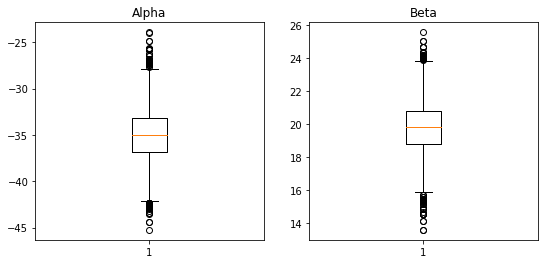

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title('Alpha')
ax[0].boxplot(alpha2G)
ax[1].set_title('Beta')
ax[1].boxplot(beta2G)
plt.show()

D'après ces graphes, tout semble bon. L'analyse et l'interprétation des résultats sont les mêmes que pour le Métropolis-Hasting ci-dessus.

# III- Modèle des valeurs extrêmes

$$p_i = 1 - \exp(-\exp( \alpha + \beta x_i ))$$
<br>Pour les paramètres $\alpha$ et $\beta$, on considère deux marches aléatoires symétriques normales :
$$\alpha_* = \alpha_t + \epsilon_t$$ 
$$\beta_* = \beta_t + \epsilon_t $$
$$\epsilon_t \stackrel{ind}{\sim} \mathcal{N}(0,1)$$
Et la probabilité d'acceptation s'écrit alors :
$$\alpha(X_t, X_*) =  min(1, \frac{g(X_*)}{g(X_t)}) = min(1, \frac{\pi(\alpha_*, \beta_* | x_i, r_i)}{\pi(\alpha_t, \beta_t | x_i, r_i)})$$
Or :
$$\pi(\alpha, \beta | x_i, r_i) \propto {\prod \limits_{i=1}^n f(r_i | x_i)} {\pi(\alpha, \beta)} $$

## 1-Metropolis-Hasting

In [0]:
def MH_extreme(sigma, N, X0, data):
    #sigma: écart-type du noyau de proposition (ici: marche aléatoire symétrique normale)
    #N: longueur de la chaîne de Markov
    #X0: état initial de la chaîne de Markov
    #data: jeu de données, i.e. matrice 8x3 (xi,ni,ri)

    #xi: concentration
    x = data[:,0]
    m = np.mean(x)
    #on centre les données pour rendre les paramètres un peu plus orthogonaux
    #cela facilite l'acceptation des données
    x = x - m
    #nombre de scarabées
    n = data[:,1]
    #nombre de scarabées tués
    r = data[:,2]
    
    chaine = np.zeros((N,2))
    chaine[0,:] = X0
    acc_rate = 0
    
    for t in range(1,N):
        current = chaine[t-1,:]
        prop_alpha = norm.rvs(loc = current[0], scale = sigma[0])
        prop_beta = norm.rvs(loc = current[1], scale = sigma[1])
        prop_p = 1 - np.exp(-np.exp(prop_alpha + prop_beta*x))     
        prop = np.array([prop_alpha, prop_beta])
        
        current_p = 1-np.exp(-np.exp(current[0] + current[1]*x))
        
        top = sum([binom.logpmf(r[i], n[i], prop_p[i]) for i in range(len(r))]) 
        bottom = sum([binom.logpmf(r[i], n[i], current_p[i]) for i in range(len(r))])
            
        acc_proba = min(1, np.exp(top-bottom))
        u = rd.uniform(0,1)
        if (u<acc_proba):
            chaine[t,:] = prop
            acc_rate += 1
        else:
            chaine[t,:] = current
    #Comme on avait centré initialement
    chaine[:,0] = chaine[:,0]  - m*chaine[:,1]
    print("Acceptance rate: ", acc_rate/N)    
    return(chaine)

In [27]:
sigma = np.array([0.2,2.7])
#1000 itérations pour la burning period, suivies de 10 000 itérations
N = 1000 + 10**4
X0 = np.array([0, 0])

chaine3MH = MH_extreme(sigma, N, X0, data)

Acceptance rate:  0.3044545454545455


Le taux d'acceptation vaut environ 30%, ce qui n'est pas en accord avec la règle des les échantillonneurs MCMC en petite dimension (50%).

In [28]:
alpha3MH = chaine3MH[1001:,0]
beta3MH = chaine3MH[1001:,1]
d = {'Name':pd.Series(['alpha','beta']),
   'Alpha':pd.Series(alpha3MH),
   'Beta':pd.Series(beta3MH)
}
df = pd.DataFrame(d)
print(df.describe())

             Alpha         Beta
count  9999.000000  9999.000000
mean    -39.751449    22.140053
std       3.124723     1.735825
min     -56.312264    16.366506
25%     -41.845708    20.905685
50%     -39.626467    22.081182
75%     -37.548524    23.313697
max     -29.353687    31.279911


On retrouve donc les mêmes valeurs qu'OpenBUGS.

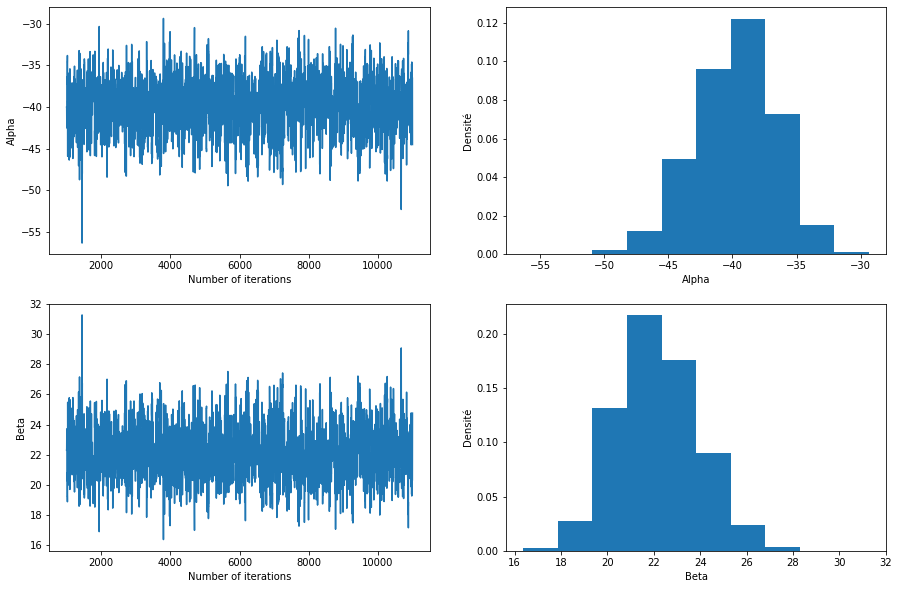

In [29]:
x = np.arange(1001, 1001+len(alpha3MH))
figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(x, alpha3MH)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha")

plt.subplot(2,2,2)
plt.hist(alpha3MH, density=True)
plt.xlabel("Alpha")
plt.ylabel("Densité")

plt.subplot(2,2,3)
plt.plot(x, beta3MH)
plt.xlabel("Number of iterations")
plt.ylabel("Beta")

plt.subplot(2,2,4)
plt.hist(beta3MH, density=True)
plt.xlabel("Beta")
plt.ylabel("Densité")

plt.show()

La chaîne a des bonnes propriétés de mélange.

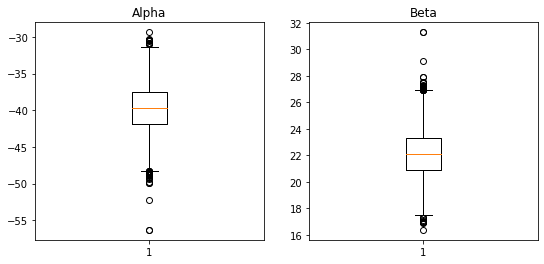

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title('Alpha')
ax[0].boxplot(alpha3MH)
ax[1].set_title('Beta')
ax[1].boxplot(beta3MH)
plt.show()

D'après ces graphes, tout semble bon donc nous pouvons continuer notre analyse et essayer d'interpréter nos résultats.
Tout d'abord, $\beta > 0$, donc augmenter la concentration de carbone disulphide faire accroître la probabilité que le scarabée meurt, ce qui est logique.
<br> A présent, cherchons la loi a posteriori de $LD_{50}$, i.e. la dose pour laquelle la probabilité de mort est de 50%. Conditionnellement à $(\alpha, \beta)^T$, on a :
$$p_i = 0.5 \iff x_i = \frac{ln(ln(2))-\alpha}{\beta} $$
Ainsi :
$$LD_{50} = \frac{ln(ln(2))-\alpha}{\beta} $$
Et voici sa loi a posteriori obtenue à partir de la chaîne de Markov :


Text(0, 0.5, 'Densité')

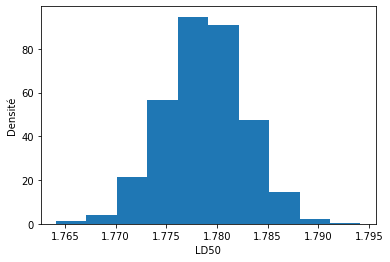

In [31]:
LD50 = (log(log(2))-alpha3MH) / beta3MH
plt.hist(LD50, density=True)
plt.xlabel("LD50")
plt.ylabel("Densité")

## 2-Gibbs avec MH

In [0]:
def Gibbs_mort3(sigma, N, X0, data):
    Y = data[:,2]
    x = data[:,0]
    m = np.mean(x)
    x = x - m
    n = data[:,1]
    
    chaine = np.zeros((N+1,2))
    chaine[0,:] = X0
    acc_rate_a, acc_rate_b = 0,0
    
    for t in range(N):
        current = chaine[t,:]
        
        #alpha
        prop_alpha = norm.rvs(loc = current[0], scale = sigma[0])

        prop_p_a = 1 - np.exp(-np.exp(prop_alpha + current[1]*x))
        current_p_a = 1 - np.exp(-np.exp(current[0] + current[1]*x))

        #passer au log car valeurs trop grandes
        topa = sum([binom.logpmf(Y[i], n[i], prop_p_a[i]) for i in range(len(Y))]) 
        bottoma = sum([binom.logpmf(Y[i], n[i], current_p_a[i]) for i in range(len(Y))])
        acc_proba_a = min(1, np.exp(topa-bottoma))
        u = rd.uniform(0,1)
        if (u<acc_proba_a):
            chaine[t+1,0] = prop_alpha
            acc_rate_a += 1
        else:
            chaine[t+1,0] = current[0]
        
        #beta
        current[0] = chaine[t+1,0]
        prop_beta = norm.rvs(loc = current[1], scale = sigma[1])

        prop_p_b = 1 - np.exp(-np.exp(current[0] + prop_beta*x))
        current_p_b = 1 - np.exp(-np.exp(current[0] + current[1]*x))

        #passer au log car valeurs trop grandes
        topb = sum([binom.logpmf(Y[i], n[i], prop_p_b[i]) for i in range(len(Y))]) 
        bottomb = sum([binom.logpmf(Y[i], n[i], current_p_b[i]) for i in range(len(Y))])
        acc_proba_b = min(1, np.exp(topb-bottomb))
        u = rd.uniform(0,1)
        if (u<acc_proba_b):
            chaine[t+1,1] = prop_beta
            acc_rate_b += 1
        else:
            chaine[t+1,1] = current[1]
    
    chaine[:,0] = chaine[:,0]  - m*chaine[:,1]
    
    print("acceptation alpha : ", acc_rate_a/N)
    print("acceptation beta : ", acc_rate_b/N) 
    return(chaine)

In [33]:
sigma = np.array([0.2,2.7])
N = 1000 + 10**4

X0 = np.array([0, 0])

chaine3G = Gibbs_mort3(sigma, N, X0, data)

acceptation alpha :  0.4278181818181818
acceptation beta :  0.5923636363636363


Le taux d'acceptation vaut environ 50% pour les deux paramètres, ce qui est en accord avec la règle des les échantillonneurs MCMC en petite dimension (2).

In [34]:
alpha3G = chaine3G[1001:,0]
beta3G = chaine3G[1001:,1]
d = {'Name':pd.Series(['alpha','beta']),
   'Alpha':pd.Series(alpha3G),
   'Beta':pd.Series(beta3G)
}
df = pd.DataFrame(d)
print(df.describe())

              Alpha          Beta
count  10000.000000  10000.000000
mean     -39.859421     22.199724
std        3.198641      1.775897
min      -51.434562     15.965513
25%      -42.021632     20.968192
50%      -39.754068     22.141745
75%      -37.644516     23.410070
max      -28.608634     28.647145


On retrouve donc les mêmes valeurs qu'OpenBUGS.

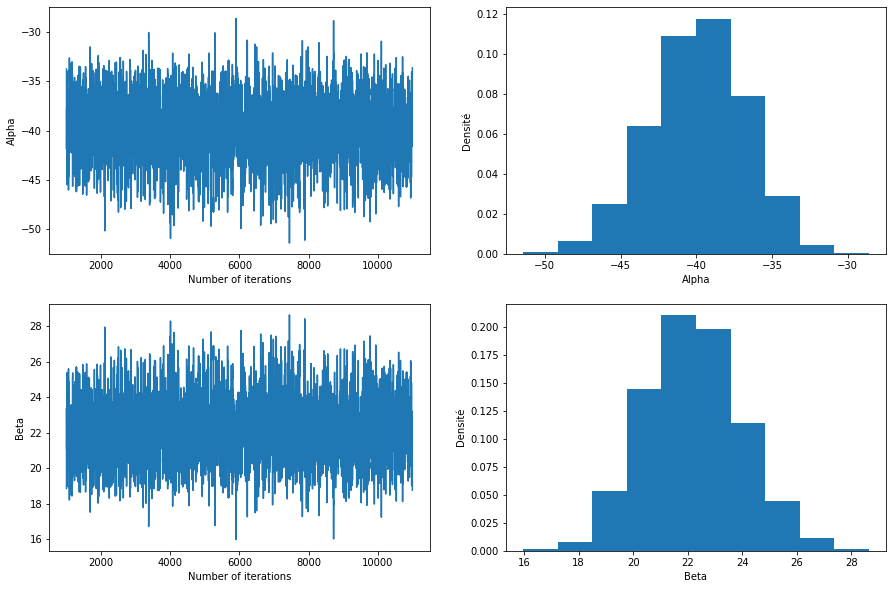

In [35]:
x = np.arange(1001, 1001+len(alpha3G))
figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(x, alpha3G)
plt.xlabel("Number of iterations")
plt.ylabel("Alpha")

plt.subplot(2,2,2)
plt.hist(alpha3G, density=True)
plt.xlabel("Alpha")
plt.ylabel("Densité")

plt.subplot(2,2,3)
plt.plot(x, beta3G)
plt.xlabel("Number of iterations")
plt.ylabel("Beta")

plt.subplot(2,2,4)
plt.hist(beta3G, density=True)
plt.xlabel("Beta")
plt.ylabel("Densité")

plt.show()

La chaîne a des bonnes propriétés de mélange.

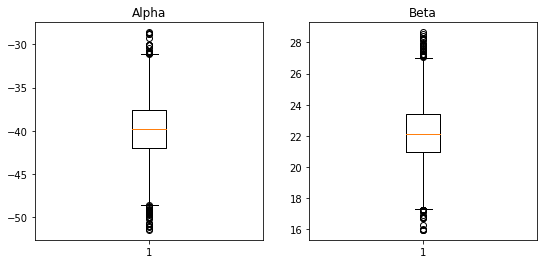

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].set_title('Alpha')
ax[0].boxplot(alpha3G)
ax[1].set_title('Beta')
ax[1].boxplot(beta3G)
plt.show()

D'après ces graphes, tout semble bon. L'analyse et l'interprétation des résultats sont les mêmes que pour le Métropolis-Hasting ci-dessus.